In [4]:
import torch
import numpy as np
from easy_transformer import EasyTransformer, EasyTransformerConfig
import easy_transformer
import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [74]:
vocab_size = 200
sequence_length = 10
batch_size = 64

tiny_cfg = EasyTransformerConfig(
    d_model=32,
    d_head=8,
    n_heads=4,
    d_mlp=32,
    n_layers=2,
    n_ctx=200,
    act_fn="solu_ln",
    d_vocab=vocab_size,
    normalization_type="LN",
    seed=0,
)
tiny_model = EasyTransformer(tiny_cfg).to(device)
cross_entropy_loss = torch.nn.CrossEntropyLoss()

Moving model to device:  cpu
Moving model to device:  cpu


In [75]:
start_token = 0
sep_token = 1
ignore_token = 2
num_special_tokens = 3


In [76]:
from algorithmic_tasks.count_greater_than_x import gen
eval_inputs, eval_outputs = gen(1000,  tiny_model.cfg.d_vocab, 20)

In [77]:
eval_outputs

tensor([[199,   0,   1,  ...,   8,   8,   8],
        [199,   0,   1,  ...,  16,  16,  17],
        [199,   1,   2,  ...,  18,  19,  20],
        ...,
        [199,   1,   2,  ...,  13,  14,  15],
        [199,   1,   2,  ...,  13,  14,  15],
        [199,   1,   2,  ...,  14,  15,  16]])

In [78]:
def get_loss(model, inputs, outputs):
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    
    output_logits = model(inputs, return_type="logits")

    seq_len = inputs.shape[1]

    loss = cross_entropy_loss(
        output_logits[:,:].reshape((-1,vocab_size)),
        outputs[:,:].reshape((-1,)))
    
    return loss

def evaluate_model(model, batch_size, print_output, number_to_print=0):
    vocab_size = model.cfg.d_vocab
    inputs,outputs = gen(batch_size,vocab_size,random.randint(5,150))

    loss = get_loss(model,inputs,outputs)

    if print_output:
      eval_loss = get_loss(model,eval_inputs, eval_outputs)
      print(eval_loss.item())

    return loss

In [81]:
loss_history = []
print('Start training')
tiny_optimizer = torch.optim.Adam(tiny_model.parameters(), lr=2e-3)
loss = evaluate_model(tiny_model, batch_size=3000, print_output=True)
for epoch in tqdm.tqdm(range(3000)):
    loss = evaluate_model(tiny_model, batch_size=batch_size, print_output=epoch % 300 == 0, number_to_print=0)
    loss.backward()
    loss_history.append(loss.item())
    tiny_optimizer.step()
    tiny_optimizer.zero_grad()

Start training
0.9271258115768433


  0%|          | 0/3000 [00:00<?, ?it/s]

0.9271258115768433


 10%|█         | 306/3000 [00:08<01:27, 30.73it/s]

1.0767035484313965


 20%|██        | 608/3000 [00:17<01:06, 36.20it/s]

0.9596127271652222


 30%|███       | 907/3000 [00:26<01:07, 31.14it/s]

0.9200640916824341


 40%|████      | 1206/3000 [00:35<00:46, 38.33it/s]

0.9913614392280579


 50%|█████     | 1507/3000 [00:44<00:48, 31.07it/s]

0.8884603977203369


 60%|██████    | 1803/3000 [00:54<00:34, 35.06it/s]

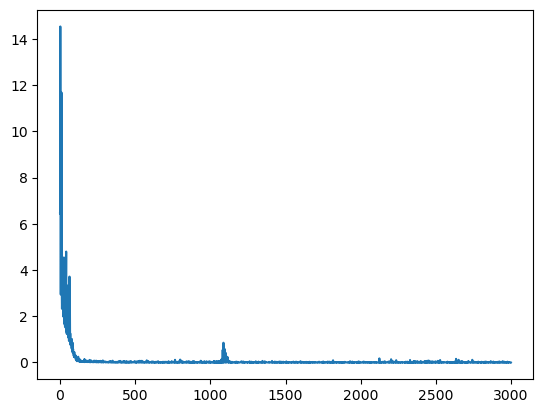

In [36]:
plt.plot(loss_history)

In [58]:
import pysvelte
def show_attention_pattern_for_input(model, input,output):
    model_cache={}
    model.cache_all(model_cache) # remove_batch_dim=True
    model(input)
    model.reset_hooks()
    tokens = [str(x) for x in input[0].tolist()]
    print('tokens', tokens, 'len(tokens)', len(tokens))
    pysvelte.AttentionMulti(tokens=tokens, attention=model_cache['blocks.0.attn.hook_attn'][0].permute(1, 2, 0)).show()
    pysvelte.AttentionMulti(tokens=tokens, attention=model_cache['blocks.1.attn.hook_attn'][0].permute(1, 2, 0)).show()


In [61]:
inputs,outputs = gen(3,vocab_size,20)
print(inputs.shape)
print(outputs.shape)
output_logits = tiny_model(inputs, return_type="logits")
predictions = output_logits.argmax(dim=2)

torch.Size([3, 21])
torch.Size([3, 21])


In [62]:
print(np.array([
    inputs[0].tolist(),
    outputs[0].tolist(),
    predictions[0].tolist()
  ]))

show_attention_pattern_for_input(tiny_model,inputs,outputs)

[[31  6  8 41 44 28 46 44 22  3 33 26 31  9 18  1  4  4 11 33 10]
 [49  0  0  1  2  2  3  4  4  4  5  5  6  6  6  6  6  6  6  7  7]
 [49  0  0  1  2  2  3  4  4  4  5  5  6  6  6  6  6  6  6  7  7]]
tokens ['31', '6', '8', '41', '44', '28', '46', '44', '22', '3', '33', '26', '31', '9', '18', '1', '4', '4', '11', '33', '10'] len(tokens) 21


In [63]:
tiny_model(torch.tensor([[1,3,4,5,6,7,5,6,6]]), return_type="logits").argmax(dim=2)

tensor([[49,  1,  2,  3,  4,  5,  6,  7,  8]])